<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94%EC%83%9D%EC%9C%A1ver3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "./drive/My Drive/Data/lettuce"

/content/drive/My Drive/Data/lettuce


In [3]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [267]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import cross_validate
import xgboost as xgb
# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 150
METRIC = 'fair'

categoricals = []
FEATURES_red = ['DAT', 'obs_time',  '시간당적색광량']
FEATURES_blue =['DAT', 'obs_time',  '시간당청색광량']
FEATURES_white=['DAT', 'obs_time',  '시간당백색광량']
FEATURES_total=['DAT', 'obs_time',  '시간당총광량']

FEATURES = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
        ]      
FEATURES_sum= ['DAT', 'obs_time', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량' ]      
FEATURES2 =['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES3 = [ 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES_dacon = ['DAT','obs_time', '내부온도관측치', 'co2관측치','내부습도관측치', 'ec관측치' 
           ,'시간당총광량']

FEATURES_night = ['DAT', 'obs_time','시간당총광량']
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)



Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [283]:
def get_time(x, numbers):
    x['DAT'] = x['DAT'].map(lambda x: f'20{numbers}010'+ str(x+1)+' ' if x<9 else f'20{numbers}01'+ str(x+1)+' ' )
    x['obs_time']=x['obs_time'].map(lambda x: x.split(':')[0]+ x.split(':')[1])
    x['시간'] = x['DAT']+x['obs_time']
    x['시간']=pd.to_datetime(x['시간'], format ='%Y%m%d %H%M')
    x[x['시간'].dt.minute == 59]['시간']= x[x['시간'].dt.minute == 59]['시간']+pd.Timedelta(1,'m')
    if 'DAT' and 'obs_time' in list(x.columns):
        x.drop(columns=['DAT','obs_time'], inplace =True)
    else: 
        x.drop(columns =['DAT'],inplace= True)
    return x

def get_light_ratio(x):
    x_light = x.copy(deep = True)
    x_light['시간당총광량']= x_light['시간당총광량'].map(lambda x: x+1e-4 if x==0 else x)
    x_light['적색/총'] =x_light.시간당적색광량 /x_light.시간당총광량
    x_light['청색/총'] =x_light.시간당청색광량 /x_light.시간당총광량
    x_light['백색/총'] =x_light.시간당백색광량 /x_light.시간당총광량
    return x_light

def get_night_time(x):
    X_light_zero = x.copy(deep= True)
    x_zero_list = list(X_light_zero['시간당총광량'].values).count(0)
    x_zero_list = pd.Series(x_zero_list)

    return x_zero_list #결과물은 시리즈로 출력

def get_daily_temp(x):
    X_daily_temp = x.copy(deep =True)
    X_daily_temp = X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].max() - X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].min() 
    X_daily_temp= pd.DataFrame(X_daily_temp)
    X_daily_temp.columns = ['일교차']
    return X_daily_temp

def day_mean(df): 
    df_mean= df.copy(deep = True)
    HOURS = 25     
    cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
    cols = np.array(cols).flatten()   
    # df_max= pd.DataFrame(columns = df.columns)                              
    df_mean = df_mean.append(df.mean(numeric_only=True), ignore_index=True)        
    ar = np.array(df_mean).flatten()                                         
    data = pd.Series(ar, index=cols)
    return data

def day_sum(df):    
    df_sum = df.copy(deep =True)
    HOURS_sum = 25   
    cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
    cols_sum = np.array(cols_sum).flatten()      
    # df_sum= pd.DataFrame(columns = df.columns) 
    df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
    ar = np.array(df_sum).flatten()                                         
    data = pd.Series(ar, index=cols_sum)
    return data 

def day_col_to_row(df):    
    df_row = df.copy(deep =True)
    HOURS_row = 24   
    cols_row = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS_row) ]
    cols_row = np.array(cols_row).flatten()      
    # df_sum= pd.DataFrame(columns = df.columns)       
    ar = np.array(df_row).flatten()                                         
    data = pd.Series(ar, index=cols_row)
    return data

def get_day(df):
    df_day = df.copy(deep =True)
    df['일자'] = df.index.day
    return df 

def get_humid_temp_co2(df):
    df_humid_temp_co2 =df.copy(deep =True)
    df_humid_temp_co2['습도_온도_co2']=df_humid_temp_co2['내부습도관측치']*df_humid_temp_co2['내부온도관측치']*df_humid_temp_co2['co2관측치']
    df_humid_temp_co2['습도_온도']= df_humid_temp_co2['내부습도관측치']*df_humid_temp_co2['내부온도관측치']
    df_humid_temp_co2['온도_co2'] =df_humid_temp_co2['내부온도관측치']*df_humid_temp_co2['co2관측치']

    df_humid_temp_co2['빛_온도'] = df_humid_temp_co2['내부온도관측치']*df_humid_temp_co2['시간당총광량']
    df_humid_temp_co2['빛_습도'] = df_humid_temp_co2['내부습도관측치']*df_humid_temp_co2['시간당총광량']
    df_humid_temp_co2['빛_co2'] = df_humid_temp_co2['co2관측치']*df_humid_temp_co2['시간당총광량']
    df_humid_temp_co2['빛_습도_온도_co2'] = df_humid_temp_co2['내부습도관측치']*df_humid_temp_co2['내부온도관측치']*df_humid_temp_co2['co2관측치']*df_humid_temp_co2['시간당총광량']
    return df_humid_temp_co2

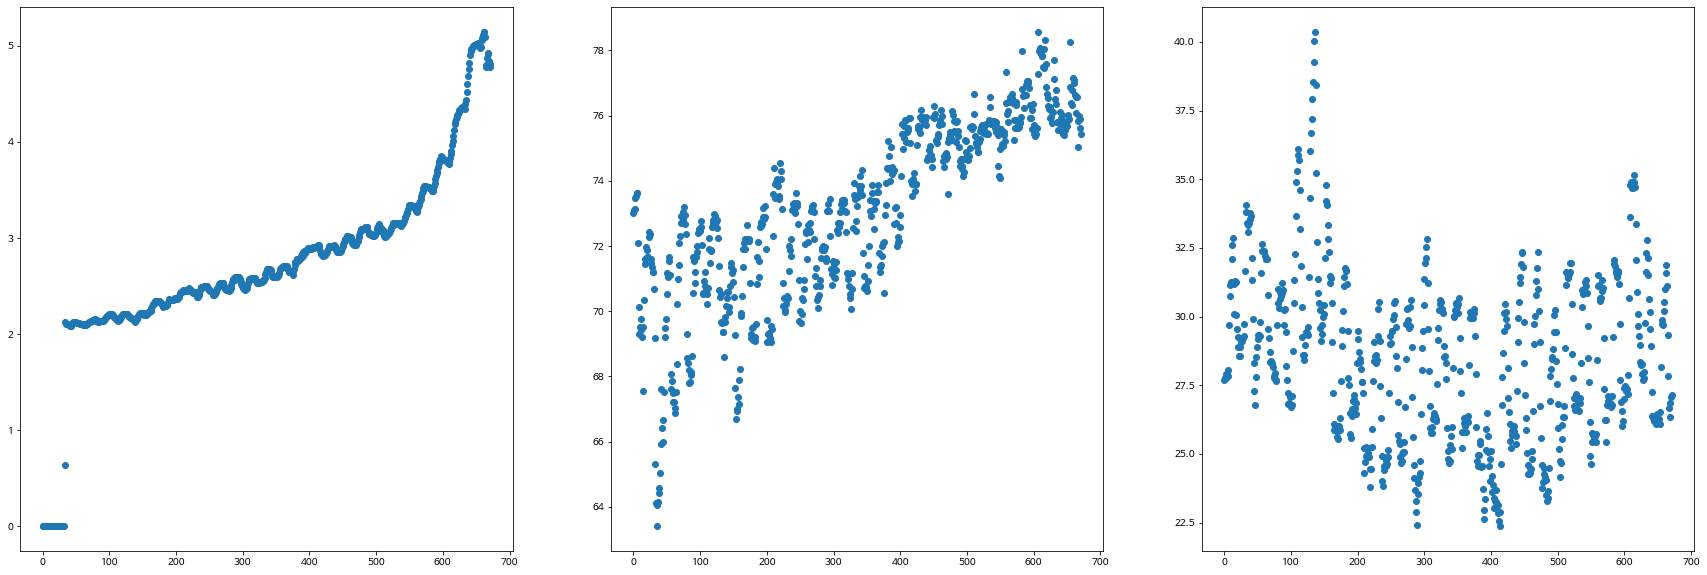

In [230]:
x=pd.read_csv('./train_input/CASE_08.csv')[FEATURES_dacon]
x_file ='./train_input/CASE_01.csv'
# numbers = re.sub(r'[^0-9]','',x_file)
# X= get_time(x,numbers)
# X.set_index('시간',inplace= True)
# get_day(X)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.scatter(x.index, x['ec관측치'])
plt.subplot(1,3,2)
plt.scatter(x.index, x['내부습도관측치'])
plt.subplot(1,3,3)
plt.scatter(x.index, x['내부온도관측치'])

In [231]:
get_humid_temp_co2(x)

,DAT,obs_time,내부온도관측치,co2관측치,내부습도관측치,ec관측치,시간당총광량,습도_온도_co2
0,0,00:00,27.680000,466.750000,73.026667,0.000000,0.0,9.434782e+05
1,0,01:00,27.770000,464.516667,73.120000,0.000000,0.0,9.432208e+05
2,0,02:00,27.766666,466.233333,73.130001,0.000000,0.0,9.467224e+05
3,0,03:00,27.896666,468.466667,73.488334,0.000000,0.0,9.603939e+05
4,0,04:00,27.921666,471.550000,73.543333,0.000000,0.0,9.683055e+05
...,...,...,...,...,...,...,...,...
667,27,19:00,26.655000,648.133333,75.036667,4.930179,0.0,1.296333e+06
668,27,20:00,26.336667,565.766667,76.000000,4.920976,0.0,1.132431e+06
669,27,21:00,26.840000,510.583333,75.895000,4.843987,0.0,1.040069e+06
670,27,22:00,27.080000,497.000000,75.633333,4.816428,0.0,1.017931e+06


In [132]:

def get_diff(y):
    
    y_diff=y.diff()
    y_diff =y_diff.fillna(y['predicted_weight_g'][0])
    return y_diff
def get_accumulate(y):
    y_acc =y.cumsum()
    return y_acc

def get_y_time(y, numbers):
    y['DAT'] = y['DAT'].map(lambda y: f'20{numbers}010'+ str(y) if y<9 else f'20{numbers}01'+ str(y))
    
    y['시간'] = y['DAT']
    y['시간']=pd.to_datetime(y['시간'], format ='%Y%m%d')
    
    
    y.drop(columns=['DAT'], inplace =True)
    
    return y

In [249]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return

    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)
            

            numbers = re.sub(r'[^0-9]','',x_file)
            x_df = get_time(x_df, numbers)
            x_df.set_index('시간', inplace=True) 
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
        
        return x_df, y_df

    def read_data(self, x_file, y_file):

        x_df = pd.read_csv(x_file)[FEATURES_dacon].ffill().bfill()
        y_df = pd.read_csv(y_file)
        x_df_night =  pd.read_csv(x_file)[FEATURES_night]

        numbers = re.sub(r'[^0-9]','',x_file)
        x_df = get_time(x_df, numbers)
        x_df.set_index('시간', inplace=True) #여기까지는 set로 묶어둘것 
        x_df =get_humid_temp_co2(x_df)
        numbers_y = re.sub(r'[^0-9]','',y_file)

        x_df_night = get_time(x_df_night, numbers)
        x_df_night.set_index('시간', inplace=True)
        x_df_night= x_df_night.groupby(x_df_night.index.date).apply(get_night_time)
        x_df_night.columns = ['소등시간']

        x_df_daily_temp = get_daily_temp(x_df)

        if (self.DataType == 'train'):
           
                
                
                y_df =get_y_time(y_df, numbers_y)
                y_df.set_index('시간', inplace=True)
                y_df = get_diff(y_df)
        else:
            y_df =get_y_time(y_df, numbers_y)
            y_df.set_index('시간', inplace=True)
            y_df = get_diff(y_df)
        # x_df = get_light_ratio(x_df)
        #     y_df.set_index('시간', inplace=True)
        # else:
        #     y_df.set_index('DAT', inplace=True)
        #     y_df = get_diff(y_df)
        \
        x_df_sum =(x_df.groupby(x_df.index.date).apply(day_sum))  
        x_add_list =x_df,x_df_night,x_df_daily_temp 
        x_add_list =x_df,x_df_daily_temp                                  
        x_df =pd.concat([x_df_sum,x_df_daily_temp,x_df_night],axis=1)
        x_df.sort_index(inplace =True)
        scaler = StandardScaler()
        scaler.fit(x_df)
        x_df.loc[:,x_df.columns] = scaler.transform(x_df)
          
                #standartscaler
        # y_df_diff = y_df.diff(axis = 0)
        # y_df_diff= y_df_diff.dropna()
        # x_df = x_df.drop(x_df.index[0],axis =0)
        # y_df =y_df.drop(y_df.index[0],axis= 0)
        x_df.index= pd.to_datetime(x_df.index)
        x_df = get_day(x_df)
        return x_df, y_df

    def read_train(self):

        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)
            
                
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
       
        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        

        
        return x_df, y_df

    def read_test(self):

        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        
        return x_df, y_df

    def read(self):

        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():

    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):

    test_x, test_y  = LoadData('test', TestNo).read()
    
    return test_x, test_y

def  load_spilit_train():

    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y   


In [245]:
X,y = LoadData('train').read_train() 


In [190]:
X


,내부온도관측치_0sum,내부습도관측치_0sum,ec관측치_0sum,시간당총광량_0sum,내부온도관측치_1sum,내부습도관측치_1sum,ec관측치_1sum,시간당총광량_1sum,내부온도관측치_2sum,내부습도관측치_2sum,...,내부습도관측치_23sum,ec관측치_23sum,시간당총광량_23sum,내부온도관측치_24sum,내부습도관측치_24sum,ec관측치_24sum,시간당총광량_24sum,일교차,소등시간,날짜
2001-01-01,-0.687557,-0.706035,0.084030,0.0,-0.133796,-1.097777,0.089012,0.0,-0.698975,-1.012077,...,-0.587646,0.144480,0.0,0.399451,-0.984531,0.112989,0.393276,1.009298,0.000000,1
2001-01-02,0.229185,-0.781703,0.021644,0.0,0.442631,-1.037371,0.027474,0.0,-0.078860,-1.118473,...,-1.184301,0.133614,0.0,0.899291,-0.978123,0.083611,2.253166,1.291766,0.000000,2
2001-01-03,0.756917,-0.767290,0.006057,0.0,1.080113,-1.092942,0.021694,0.0,0.511248,-1.245466,...,-1.279701,0.163926,0.0,0.055617,-1.204132,0.110204,0.459119,0.260147,0.000000,3
2001-01-04,-0.437263,-1.545583,0.045300,0.0,0.063078,-1.741654,0.058611,0.0,-0.602291,-1.597263,...,-1.050094,0.184414,0.0,-0.453111,-1.308497,0.137557,2.253166,0.025440,0.000000,4
2001-01-05,-0.379966,-1.284349,0.092485,0.0,-0.551043,-0.900846,0.088508,0.0,-0.442261,-1.121907,...,-0.464759,0.195544,0.0,-0.096266,-0.951742,0.145548,0.775859,0.239677,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-01-24,-0.189824,1.080236,-1.032518,0.0,-0.102365,1.033517,-1.046434,0.0,-0.054449,1.056515,...,1.119891,-0.963537,0.0,-0.667942,1.108077,-0.988511,0.299072,-0.304012,-0.473118,24
2027-01-25,-0.990644,1.083890,-1.504932,0.0,-0.909998,1.091681,-1.521901,0.0,-0.865282,1.090213,...,1.127843,-1.406190,0.0,-1.379557,1.032469,-1.455500,0.301228,0.335553,-0.473118,25
2027-01-26,-0.787547,1.101869,-2.072349,0.0,-0.765197,1.106513,-2.069941,0.0,-0.698488,1.074909,...,1.033876,-1.677429,0.0,-0.780717,1.040226,-1.906611,0.309588,0.207640,-0.473118,26
2027-01-27,-0.297800,1.090175,-2.380062,0.0,-0.309578,1.130070,-2.389262,0.0,-0.304029,1.108461,...,1.058382,-1.574545,0.0,-0.866013,1.082789,-1.995982,0.307815,-0.256886,-0.473118,27


In [112]:
y

,DAT,predicted_weight_g
1,1.0,0.014068
2,1.0,0.084134
3,1.0,0.157729
4,1.0,0.051622
5,1.0,1.466607
...,...,...
23,1.0,7.660831
24,1.0,7.504703
25,1.0,7.560664
26,1.0,12.343206


In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

SAMPLE_NUM = 1440
COLS = FEATURES[1:]
fig = make_subplots(rows=len(COLS), cols=1, subplot_titles=COLS)
for row, col in enumerate(COLS, 1):
    fig.add_trace(go.Scatter(x=np.arange(SAMPLE_NUM), y=train_x[col].iloc[:SAMPLE_NUM], showlegend=False,
                        mode='lines+markers', name=col, marker=dict(color="orange")), row=row, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample data snippets")
fig.show()

KeyError: ignored

In [ ]:
#하루에 빛이 없는 시간( =소등시간)이 얼마나되는지

# def get_night_time(x):
#     X_light_zero = x.copy(deep= True)
#     X_light_zero = X_light_zero[X_light_zero['시간당총광량']==0]
#     X_count = X_light_zero.groupby(X_light_zero.index.date).count()
#     X_night =X_count.iloc[:,11]
#     X_night= pd.DataFramx_zero_list = list(x['시간당총광량'].values).count(0)
#     x_zero_list = pd.Series(x_zero_list)
    # X= pd.DataFrame(X)

   

    
    # X= pd.DataFrame(X)


# pd.concat([get_night_time(X), get_daily_temp(X)],axis= 1)
X=pd.read_csv('./train_input/CASE_01.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
X= get_time(X,numbers)
X.set_index('시간',inplace= True)
get_daily_temp(X)




FileNotFoundError: ignored

위의 결과로 소등시간이 일자 별로 다른 것을 확인 

In [ ]:
x=pd.read_csv('./train_input/CASE_01.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
x =get_time(x,numbers)
x.set_index('시간',inplace= True)
x_zero_list =x.copy(deep =True)

x_zero_list['소등시간'] = list(X_light_zero.groupby(X_light_zero.index.date)['시간당총광량'].values).count(0)

AttributeError: ignored

In [ ]:
plt.figure(figsize=(40, 12))
for col in X.columns: 

    plt.subplot(10,10,list(X.columns).index(col)+1)
    plt.tight_layout()
    plt.title(col)
    plt.plot(X.index, X[col])
# plt.subplot(2,7,2)

# plt.plot(X.index, X['내부습도관측치'])    

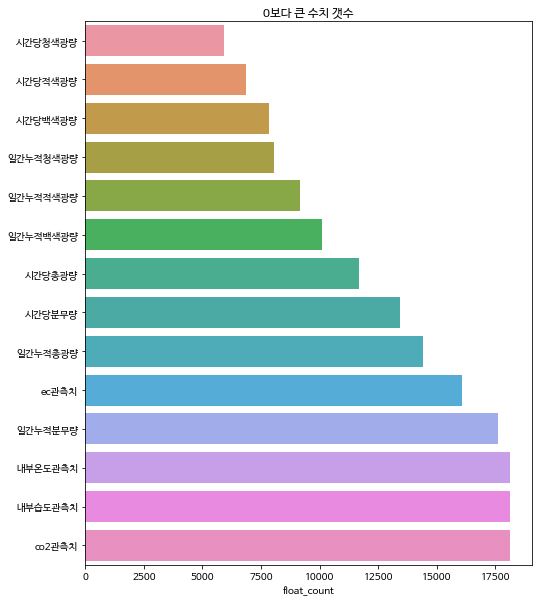

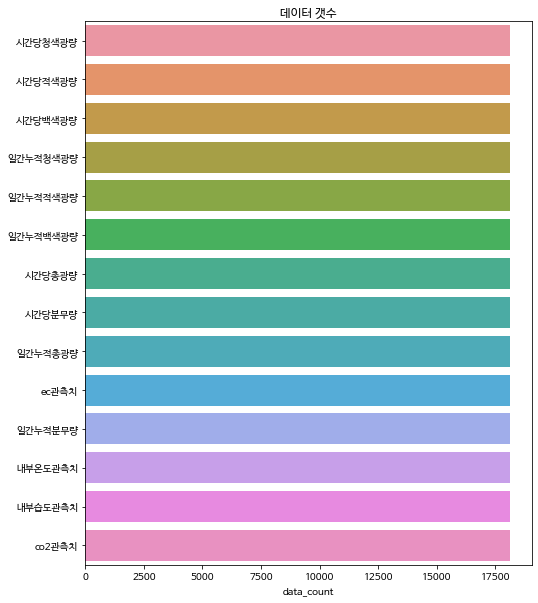

In [ ]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

In [276]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [271]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [250, 511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

In [269]:
def test_(x,y):
    X=x.copy(deep =True)
   
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=5)
    nmse = cross_validate(xg_reg, X, y,
                      scoring=['neg_mean_squared_error'],
                      return_train_score=True,
                      cv=5, n_jobs=-1)
    mse = -1 * nmse['test_neg_mean_squared_error']
    rmse = np.sqrt(mse)
    avg_rmse = round(np.mean(rmse),4)
    print(f"RMSE :{avg_rmse :.4f}")
    return avg_rmse

In [270]:
X, y= LoadData('train').read_train()
test_(X, y)

RMSE :3.3199


3.3199

max_bin: 250. RMSE:  2.630
max_bin: 511. RMSE:  2.768
max_bin:2047. RMSE:  2.768
max_bin:4095. RMSE:  2.768
Best max_bin: 250


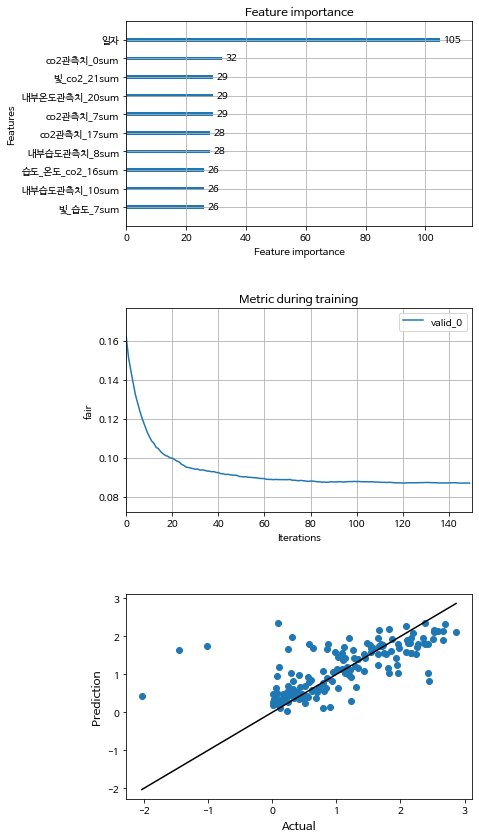

Features Importance Split & Gain...
               feature  split       gain
302                 일자    105  38.189802
85         co2관측치_7sum     29   6.450170
268       시간당총광량_22sum     23   4.775496
109        co2관측치_9sum     20   1.809429
1          co2관측치_0sum     32   1.236240
280       시간당총광량_23sum     15   1.114404
86        내부습도관측치_7sum     25   1.109445
122      내부습도관측치_10sum     26   0.936562
196       시간당총광량_16sum     23   0.912001
13         co2관측치_1sum     21   0.883969
134      내부습도관측치_11sum     13   0.873391
205       co2관측치_17sum     28   0.833256
80           빛_온도_6sum     15   0.785750
33           빛_습도_2sum      2   0.763573
124       시간당총광량_10sum     18   0.687301
98        내부습도관측치_8sum     28   0.615772
244       시간당총광량_20sum     11   0.587934
262        빛_co2_21sum     29   0.583288
235       온도_co2_19sum     13   0.541574
121       co2관측치_10sum     18   0.537934
265       co2관측치_22sum      6   0.535095
103        온도_co2_8sum     21   0.531649
240      내부온도관측치_20su

In [284]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [285]:
max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 5                                                                       # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)
    
    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['predicted_weight_g'] = pred_Y
    test_y['predicted_weight_g'] = test_y['predicted_weight_g'].cumsum()
    test_y.index= test_y.index.day

    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')
import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin: 250. RMSE:  2.630
max_bin: 511. RMSE:  2.768
max_bin:2047. RMSE:  2.768
max_bin:4095. RMSE:  2.768
Best max_bin: 250
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i